## Assignment 2.3: Text classification via RNN (30 points)

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN. An additional goal is to learn high abstactions of the **torchtext** module that consists of data processing utilities and popular datasets for natural language.

In [0]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Preparing Data

In [0]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

In [0]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

In [20]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.36 s, sys: 28.8 ms, total: 1.39 s
Wall time: 1.39 s


In [0]:
LABEL.build_vocab(trn)

The vocab.freqs is a collections.Counter object, so we can take a look at the most frequent words.

In [22]:
TEXT.vocab.freqs.most_common(10)

[('the', 225730),
 ('a', 111991),
 ('and', 111420),
 ('of', 101154),
 ('to', 93965),
 ('is', 73190),
 ('in', 63482),
 ('i', 49630),
 ('this', 48954),
 ('that', 46542)]

### Creating the Iterator (2 points)

During training, we'll be using a special kind of Iterator, called the **BucketIterator**. When we pass data into a neural network, we want the data to be padded to be the same length so that we can process them in batch:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

Complete the definition of the **BucketIterator** object

In [0]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=False,
        sort_key=lambda x: len(x),
        sort_within_batch=False,
        device='cpu',
        repeat=False
)

Let's take a look at what the output of the BucketIterator looks like. Do not be suprised **batch_first=True**

In [24]:
batch = next(train_iter.__iter__()); batch.text

tensor([[  10,   10,    9,  ..., 5671,    9, 1781],
        [  24,   24,  196,  ...,  821,  100,  154],
        [  61, 1618,  104,  ..., 2371,   37,  427],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])

The batch has all the fields we passed to the Dataset as attributes. The batch data can be accessed through the attribute with the same name.

In [25]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

In [26]:
batch.text.shape

torch.Size([1001, 64])

### Define the RNN-based text classification model (10 points)

Start simple first. Implement the model according to the shema below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [0]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.emb_voc = len(TEXT.vocab)
        self.num_layers = 1
        
        self.emb = nn.Embedding(self.emb_voc, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=self.num_layers)
        self.fc = nn.Linear(hidden_dim, 2)
            
    def forward(self, seq):
        seq = self.emb(seq)
        starting_hidden = self.init_hidden(seq.shape)
        preds, hidden = self.rnn(seq, starting_hidden)
        preds = self.fc(hidden)
        return preds.squeeze(), hidden
    
    def init_hidden(self, shape):
        return torch.zeros((self.num_layers, shape[1], self.hidden_dim))

In [0]:
em_sz = 50
nh = 50
model = RNNBaseline(nh, emb_dim=em_sz)

In [35]:
model

RNNBaseline(
  (emb): Embedding(201579, 50)
  (rnn): GRU(50, 50)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

Define the optimization and the loss functions.

In [0]:
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

Define the stopping criteria.

In [0]:
epochs = 50

In [0]:
epoch_losses = []
val_losses = []

In [0]:
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for idx, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label

        opt.zero_grad()
        preds, _ = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_iter)
    
    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label
        
        preds, _ = model(x) 
        loss = loss_func(preds, y)
        val_loss += loss.item()
        
    val_loss /= len(val_iter)

    if epoch > 10 and sum(val_losses[-5:]) / 5 > sum(val_losses[-10:]) / 10:
      break

    epoch_losses.append(epoch_loss)
    val_losses.append(val_loss)

In [43]:
epoch

12

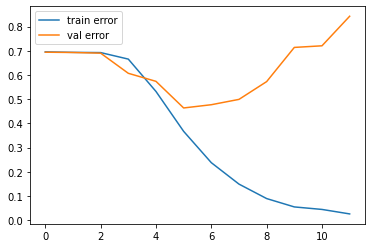

In [53]:
from matplotlib import pyplot as plt

plt.plot(range(len(epoch_losses)), epoch_losses, label='train error')
plt.plot(range(len(val_losses)), val_losses, label='val error')
plt.legend()

### Calculate performance of the trained model (5 points)

In [0]:
batch_size = 64
accuracy = 0
true_positive = 0
false_negative = 0
false_positive = 0

model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label
    
    preds, _= model(x)
    preds = preds.argmax(dim=-1)
    
    accuracy += (preds == y).sum()
    true_positive += ((preds == y) * y * preds).sum()
    false_positive += ((preds != y) * (1 - y) * preds).sum()
    false_negative += ((preds != y) * y * (1 - preds)).sum()

In [0]:
accuracy = accuracy.item()
true_positive = true_positive.item()
false_positive = false_positive.item()
false_negative = false_negative.item()

In [0]:
accuracy = accuracy / batch_size / len(test_iter) * 100
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

In [47]:
print('Accuracy {}%'.format(round(accuracy, 4)))
print('Precision {}'.format(round(precision, 4)))
print('Recall {}'. format(round(recall, 4)))
print('F1 {}'.format(round(2 * precision * recall / (precision + recall), 4)))

Accuracy 79.7075%
Precision 0.7504
Recall 0.8926
F1 0.8153


# All experiments well be held inside one training session

### 1. Slanted triangular learning rates
### 2. Adding new preceding layers after training the main model
### 3. Adding BatchNorm & DropOut to starting layers after training

In [0]:
from math import floor

class SLTR:
    def __init__(self, training_iterations, cut_frac=0.1, ratio=32):
        self.training_iterations = training_iterations
        self.cut_frac = cut_frac
        self.ratio = ratio
        self.cut = floor(training_iterations * cut_frac)
    
    def __call__(self, it):
        if it < self.cut:
            p = it / self.cut
        else:
            p = 1 - (it - self.cut) / (self.cut * (1 / self.cut_frac - 1))
        return (1 + p * (self.ratio - 1)) / self.ratio

In [0]:
model1_start = RNNBaseline(nh, emb_dim=em_sz)

In [50]:
model1_start

RNNBaseline(
  (emb): Embedding(201579, 50)
  (rnn): GRU(50, 50)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

In [0]:
epochs = 10

In [0]:
scheduler_func = SLTR(epochs * len(train_iter))
opt = optim.Adam(model1_start.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(opt, lambda e: scheduler_func(e))
loss_func = nn.CrossEntropyLoss()

In [0]:
epoch_losses1_start = []
val_losses1_start = []

for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    model1_start.train() 
    for idx, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label

        opt.zero_grad()
        preds, _ = model1_start(x)
        loss = loss_func(preds, y)
        loss.backward()
        
        opt.step()
        scheduler.step()
        running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_iter)
    
    val_loss = 0.0
    model1_start.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label
        
        preds, _ = model1_start(x) 
        loss = loss_func(preds, y)
        val_loss += loss.item()
        
    val_loss /= len(val_iter)

    epoch_losses1_start.append(epoch_loss)
    val_losses1_start.append(val_loss)

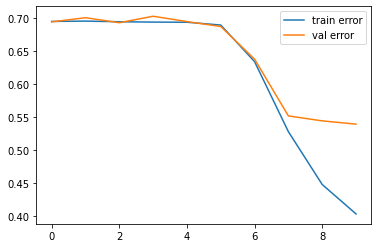

In [57]:
plt.plot(range(len(epoch_losses1_start)), epoch_losses1_start, label='train error')
plt.plot(range(len(val_losses1_start)), val_losses1_start, label='val error')
plt.legend()

In [0]:
batch_size = 64
accuracy1_start = 0
true_positive1_start = 0
false_negative1_start = 0
false_positive1_start = 0

model1_start.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label
    
    preds, _= model1_start(x)
    preds = preds.argmax(dim=-1)
    
    accuracy1_start += (preds == y).sum()
    true_positive1_start += ((preds == y) * y * preds).sum()
    false_positive1_start += ((preds != y) * (1 - y) * preds).sum()
    false_negative1_start += ((preds != y) * y * (1 - preds)).sum()

In [0]:
accuracy1_start = accuracy1_start.item()
true_positive1_start = true_positive1_start.item()
false_positive1_start = false_positive1_start.item()
false_negative1_start = false_negative1_start.item()

In [0]:
accuracy1_start = accuracy1_start / batch_size / len(test_iter) * 100
precision1_start = true_positive1_start / (true_positive1_start + false_positive1_start)
recall1_start = true_positive1_start / (true_positive1_start + false_negative1_start)

In [61]:
print('Accuracy {}%'.format(round(accuracy1_start, 4)))
print('Precision {}'.format(round(precision1_start, 4)))
print('Recall {}'. format(round(recall1_start, 4)))
print('F1 {}'.format(round(2 * precision1_start * recall1_start / (precision1_start + recall1_start), 4)))

Accuracy 74.948%
Precision 0.7602
Recall 0.731
F1 0.7453


In [0]:
for param in model1_start.parameters():
    param.requires_grad = False

In [0]:
class NewStackModel(nn.Module):
    def __init__(self, batch_size, input_size, fc_hidden_1, fc_hidden_2, model, p1=0.5, p2=0.5):
        super().__init__()
        
        self.batch_size = batch_size
        self.input_size = input_size
        self.fc_hidden_1 = fc_hidden_1
        self.fc_hidden_2 = fc_hidden_2
        self.p1 = p1
        self.p2 = p2
        self.model = model
        
        self.bn1 = nn.BatchNorm1d(batch_size)
        self.rulu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p1)
        self.fc1 = nn.Linear(input_size, fc_hidden_2)
        self.bn2 = nn.BatchNorm1d(batch_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p2)
        self.fc2 = nn.Linear(fc_hidden_2, 2)
    
    def forward(self, x):
        _, x = self.model(x)
        x = self.bn1(x)
        x = self.rulu1(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
epochs = 30

hidden1 = 50
hidden2 = 50

In [0]:
model1 = NewStackModel(batch_size, nh, hidden1, hidden2, model1_start)

In [66]:
model1

NewStackModel(
  (model): RNNBaseline(
    (emb): Embedding(201579, 50)
    (rnn): GRU(50, 50)
    (fc): Linear(in_features=50, out_features=2, bias=True)
  )
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rulu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [0]:
scheduler_func = SLTR(epochs * len(train_iter))
opt = optim.SGD(model1.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.LambdaLR(opt, lambda e: scheduler_func(e))
loss_func = nn.CrossEntropyLoss()

In [0]:
epoch_losses1 = []
val_losses1 = []


for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    model1.train() 
    for idx, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label

        if x.shape[-1] != batch_size:
            continue
        
        opt.zero_grad()
        preds = model1(x).squeeze()
        loss = loss_func(preds, y)
        loss.backward()

        opt.step()
        scheduler.step()
        running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_iter)
    
    val_loss = 0.0
    model1.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label
        
        if x.shape[-1] != batch_size:
            continue
        
        preds = model1(x).squeeze()
        loss = loss_func(preds, y)
        val_loss += loss.item()
        
    val_loss /= len(val_iter)
    
    if epoch > 10 and sum(val_losses[-5:]) / 5 > sum(val_losses[-10:]) / 10:
      break
    
    val_losses1.append(val_loss)
    epoch_losses1.append(epoch_loss)

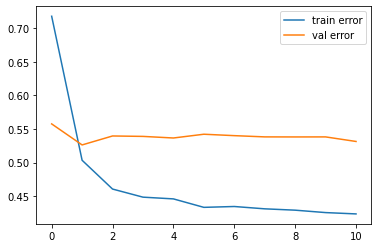

In [70]:
plt.plot(range(len(epoch_losses1)), epoch_losses1, label='train error')
plt.plot(range(len(val_losses1)), val_losses1, label='val error')
plt.legend()

In [0]:
batch_size = 64
accuracy1 = 0
true_positive1 = 0
false_negative1 = 0
false_positive1 = 0

model1.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label
    
    if x.shape[-1] != batch_size:
        break
    
    preds = model1(x)
    preds = preds.argmax(dim=-1)
    
    accuracy1 += (preds == y).sum()
    true_positive1 += ((preds == y) * y * preds).sum()
    false_positive1 += ((preds != y) * (1 - y) * preds).sum()
    false_negative1 += ((preds != y) * y * (1 - preds)).sum()

In [0]:
accuracy1 = accuracy1.item()
true_positive1 = true_positive1.item()
false_positive1 = false_positive1.item()
false_negative1 = false_negative1.item()

In [0]:
accuracy1 = accuracy1 / batch_size / len(test_iter) * 100
precision1 = true_positive1 / (true_positive1 + false_positive1)
recall1 = true_positive1 / (true_positive1 + false_negative1)

In [74]:
print('Accuracy {}%'.format(round(accuracy1, 4)))
print('Precision {}'.format(round(precision1, 4)))
print('Recall {}'. format(round(recall1, 4)))
print('F1 {}'.format(round(2 * precision1 * recall1 / (precision1 + recall1), 4)))

Accuracy 74.8402%
Precision 0.7611
Recall 0.7286
F1 0.7445
